In [1]:
import numpy as np
import quimb.tensor as qtn
import qecsim.paulitools as pt
import matplotlib.pyplot as plt
from tqdm import tqdm

In [19]:
p_depolarising = 0.2
d_channel = 0.5 * np.array(
            [
                [
                    np.sqrt(4 - 3 * p_depolarising),
                    np.sqrt(p_depolarising),
                    np.sqrt(p_depolarising),
                    np.sqrt(p_depolarising),
                ],
                [
                    np.sqrt(p_depolarising),
                    -np.sqrt(4 - 3 * p_depolarising),
                    np.sqrt(p_depolarising),
                    np.sqrt(p_depolarising),
                ],
                [
                    np.sqrt(p_depolarising),
                    np.sqrt(p_depolarising),
                    -np.sqrt(4 - 3 * p_depolarising),
                    np.sqrt(p_depolarising),
                ],
                [
                    np.sqrt(p_depolarising),
                    np.sqrt(p_depolarising),
                    np.sqrt(p_depolarising),
                    np.sqrt(4 - 3 * p_depolarising),
                ],
            ]
)
np.round(d_channel @ np.transpose(d_channel), 3)

array([[ 1.   ,  0.1  ,  0.1  ,  0.512],
       [ 0.1  ,  1.   , -0.312,  0.1  ],
       [ 0.1  , -0.312,  1.   ,  0.1  ],
       [ 0.512,  0.1  ,  0.1  ,  1.   ]])

In [2]:
def pauli_to_mps(pauli_string: str) -> str:
    """
    This function converts a Pauli string to our MPS decoder string.
    Example: "IXYZ" -> "00101101".

    Parameters
    ----------
    pauli_string : str
        The Pauli string.

    Returns
    -------
    mps_string : str
        The MPS string.
    """
    mps_string = ""
    for pauli in pauli_string:
        if pauli == "I":
            mps_string += "00"
        elif pauli == "X":
            mps_string += "10"
        elif pauli == "Y":
            mps_string += "11"
        elif pauli == "Z":
            mps_string += "01"
        else:
            raise ValueError(f"Invalid Pauli encountered -- {pauli}.")

    return mps_string

In [3]:
def initial_bsc_mps(message,nbits,prob):
    """
    Returns a product state of a binary message with a binary symmetric channel
    applied to each bit. The message is given as an int in most-significant-bit-first
    convention. The state returned is a quimb MatrixProductState object.
    Arguments:
        message : str
            The message
        nbits : int
            Length in bits of the message
        prob : np.float
            Probability of the binary symmetric channel
    Returns:
        mps : quimb.tensor.tensor_1d.MatrixProductState
            Product state
    """
    binx   = "00" + message
    arrays = np.zeros([len(binx),1,1,2])
    noise  = np.sqrt(np.array([[1-prob,prob],[prob,1-prob]]))
    # First two bits are logical:
    arrays[0,0,0] = np.array([0.5,0.5])
    arrays[1,0,0] = np.array([0.5,0.5])
    for i,b in enumerate(binx[2:]):
        arrays[i+2] = noise[int(b)].reshape([1,1,2])
    mps = qtn.tensor_1d.MatrixProductState(arrays)
    return mps

def mpo_from_tensorlist(indices,tensors):
    """
    Returns n-bit MPO built by stringing together given tensors.
    Arguments:
        indices : list of ints
            List of tensor indices
        tensors : list of np.array
            List of tensors
    Returns:
        mpo : quimb.tensor.tensor_1d.MatrixProductOperator
            The projector in matrix product operator form
    """
    tensor_list = [tensors[i] for i in indices]
    mpo = qtn.tensor_1d.MatrixProductOperator(tensor_list,'udlr')
    return mpo

def even_parity_mpo(bits,nbits):
    """
    Returns a projector to the even-parity subspace of a subset of the bits
    in a state. The projector returned is a quimb MatrixProductOperator object.
    Arguments:
        bits : list of ints
            List of bit indices whose parity the operator will project
        nbits : int
            Total number of bits
    Returns:
        mpo : quimb.tensor.tensor_1d.MatrixProductOperator
            The projector in matrix product operator form
    """
    # Define necessary tensors; **nb** index convention is 'udlr':
    parity        = np.zeros([2,2,2,2])
    parity[0,0]   = np.eye(2)
    parity[1,1]   = np.array([[0,1],[1,0]])
    end_parity_l  = parity[:,:,0].reshape([2,2,1,2])
    end_parity_r  = parity[:,:,0].reshape([2,2,2,1])
    swap          = np.zeros([2,2,2,2])
    swap[0,0]     = np.eye(2)
    swap[1,1]     = np.eye(2)
    iden          = np.zeros([2,2,1,1])
    iden[:,:,0,0] = np.eye(2)
    tensors = [iden,swap,parity,end_parity_l,end_parity_r]
    # Build an index list, then use it to build a tensor list:
    idrange = np.arange(nbits)
    indices = np.zeros(nbits,int)
    bits_sorted   = np.sort(bits)
    indices[idrange<bits_sorted[0]]  = 0
    indices[idrange>bits_sorted[0]]  = 1
    indices[idrange>bits_sorted[-1]] = 0
    indices[bits_sorted[1:-1]] = 2
    indices[bits_sorted[0]] = 3
    indices[bits_sorted[-1]] = 4
    tensor_list = [tensors[i] for i in indices]
    # Build and return the quimb MPO object:
    mpo = qtn.tensor_1d.MatrixProductOperator(tensor_list,'udlr')
    return mpo

def logical_mpo(bits,nbits):
    """
    Applies logical operator on bits.
    
    Arguments:
        bits : list of ints
            List of bit indices; first bit is logical
        nbits : int
            Total number of bits
    Returns:
        mpo : quimb.tensor.tensor_1d.MatrixProductOperator
            The logical in matrix product operator form
    """
    # Define necessary tensors; **nb** index convention is 'udlr':
    cid           = np.zeros([2,2,1,2])
    cid[:,0,0,:]  = np.eye(2)
    cid[:,1,0,:]  = np.eye(2)
    parity        = np.zeros([2,2,2,2])
    parity[0,0]   = np.eye(2)
    parity[1,1]   = np.array([[0,1],[1,0]])
    end_parity_r  = parity[:,:,0].reshape([2,2,2,1])
    swap          = np.zeros([2,2,2,2])
    swap[0,0]     = np.eye(2)
    swap[1,1]     = np.eye(2)
    iden          = np.zeros([2,2,1,1])
    iden[:,:,0,0] = np.eye(2)
    tensors = [iden,swap,parity,cid,end_parity_r]
    # Build an index list, then use it to build a tensor list:
    idrange = np.arange(nbits)
    indices = np.zeros(nbits,int)
    bits_sorted   = np.sort(bits)
    indices[idrange<bits_sorted[0]]  = 0
    indices[idrange>bits_sorted[0]]  = 1
    indices[idrange>bits_sorted[-1]] = 0
    indices[bits_sorted[1:-1]] = 2
    indices[bits_sorted[0]] = 3
    indices[bits_sorted[-1]] = 4
    tensor_list = [tensors[i] for i in indices]
    # Build and return the quimb MPO object:
    mpo = qtn.tensor_1d.MatrixProductOperator(tensor_list,'udlr')
    return mpo

def shor(message,bias=0.1):
    """
    Returns MPS-MPO "spacetime" that implements Shor's code starting from
    an error MPS with bias channel applied.
    Arguments:
        message : int
            Error state in symplectic formalism; expected to be 16 bits
        bias : float
            Bias for the bias channel
    Returns:
        rdm : quimb.tensor.tensor_1d.MatrixProductOperator
            The marginal RDM over logicals
    """
    mpos = []
    # X stabs
    mpos.append(even_parity_mpo([2, 4, 6, 8,10,12],20))
    mpos.append(even_parity_mpo([8,10,12,14,16,18],20))
    # Z stabs
    mpos.append(even_parity_mpo([ 3, 5],20))
    mpos.append(even_parity_mpo([ 5, 7],20))
    mpos.append(even_parity_mpo([ 9,11],20))
    mpos.append(even_parity_mpo([11,13],20))
    mpos.append(even_parity_mpo([15,17],20))
    mpos.append(even_parity_mpo([17,19],20))
    # logicals
    mpos.append(logical_mpo([0, 2, 4, 6],20))
    mpos.append(logical_mpo([1, 3, 9,15],20))
    mps = initial_bsc_mps(message,20,bias)
    mps_current = mps.copy(deep=True)
    for mpo in mpos:
        mps_current = mpo.apply(mps_current)
    rdm = mps_current.ptr([0,1])
    result = np.diag(rdm.to_dense())
    logical = result / np.linalg.norm(result, ord=1)
    if np.argmax(logical) == 0:
        return "I", logical
    if np.argmax(logical) == 1:
        return "X", logical
    if np.argmax(logical) == 2:
        return "Z", logical
    if np.argmax(logical) == 3:
        return "Y", logical

In [4]:
one_qubit_paulis = pt.ipauli(n_qubits=9, min_weight=1, max_weight=1)
two_qubit_paulis = pt.ipauli(n_qubits=9, min_weight=2, max_weight=2)
three_qubit_paulis = pt.ipauli(n_qubits=9, min_weight=3, max_weight=3)

In [5]:
one_qubit_errors = [pauli_to_mps(pauli) for pauli in one_qubit_paulis]
two_qubit_errors = [pauli_to_mps(pauli) for pauli in two_qubit_paulis]
three_qubit_errors = [pauli_to_mps(pauli) for pauli in three_qubit_paulis]

In [6]:
one_qubit_outputs = [shor(error) for error in tqdm(one_qubit_errors)]
one_qubit_corrections = [output[0] for output in one_qubit_outputs]

100%|██████████| 27/27 [00:00<00:00, 29.88it/s]


In [7]:
two_qubit_outputs = [shor(error) for error in tqdm(two_qubit_errors)]
two_qubit_corrections = [output[0] for output in two_qubit_outputs]

100%|██████████| 324/324 [00:10<00:00, 29.69it/s]


In [8]:
three_qubit_outputs = [shor(error) for error in tqdm(three_qubit_errors)]
three_qubit_corrections = [output[0] for output in three_qubit_outputs]

100%|██████████| 2268/2268 [01:15<00:00, 30.06it/s]


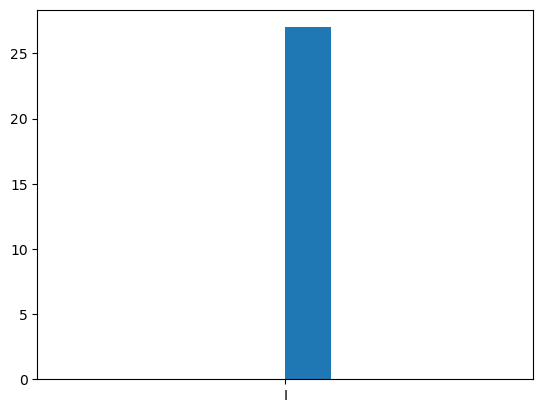

In [9]:
plt.hist(one_qubit_corrections)
plt.show()

In [10]:
len(two_qubit_corrections)

324

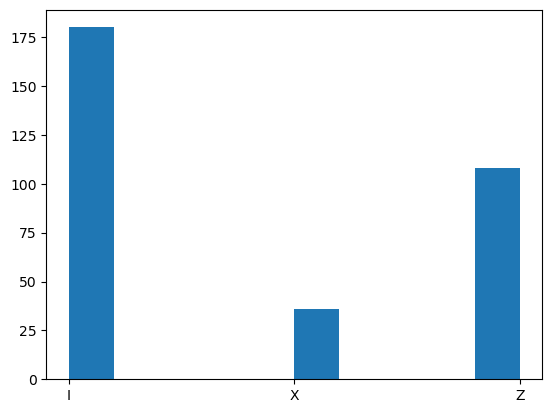

In [11]:
plt.hist(two_qubit_corrections)
plt.show()

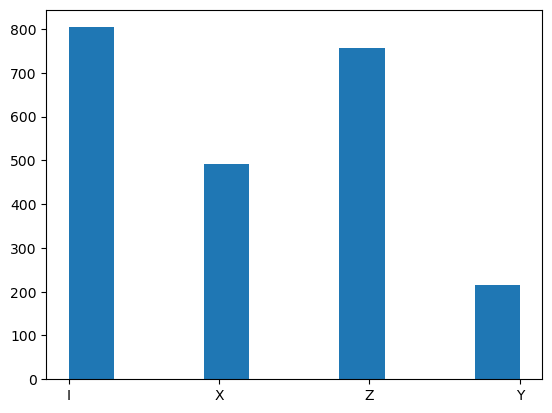

In [12]:
plt.hist(three_qubit_corrections)
plt.show()

In [13]:
one_qubit_paulis = list(pt.ipauli(n_qubits=9, min_weight=1, max_weight=1))
two_qubit_paulis = list(pt.ipauli(n_qubits=9, min_weight=2, max_weight=2))
three_qubit_paulis = list(pt.ipauli(n_qubits=9, min_weight=3, max_weight=3))

In [16]:
c = 0
for i, correction in enumerate(two_qubit_corrections):
    if correction=="I":
        c+=1
        print(
            two_qubit_paulis[i]
            )

XXIIIIIII
XZIIIIIII
XYIIIIIII
ZXIIIIIII
YXIIIIIII
XIXIIIIII
XIZIIIIII
XIYIIIIII
ZIXIIIIII
YIXIIIIII
XIIZIIIII
ZIIXIIIII
ZIIZIIIII
ZIIYIIIII
YIIZIIIII
XIIIZIIII
ZIIIXIIII
ZIIIZIIII
ZIIIYIIII
YIIIZIIII
XIIIIZIII
ZIIIIXIII
ZIIIIZIII
ZIIIIYIII
YIIIIZIII
XIIIIIZII
ZIIIIIXII
ZIIIIIZII
ZIIIIIYII
YIIIIIZII
XIIIIIIZI
ZIIIIIIXI
ZIIIIIIZI
ZIIIIIIYI
YIIIIIIZI
XIIIIIIIZ
ZIIIIIIIX
ZIIIIIIIZ
ZIIIIIIIY
YIIIIIIIZ
IXXIIIIII
IXZIIIIII
IXYIIIIII
IZXIIIIII
IYXIIIIII
IXIZIIIII
IZIXIIIII
IZIZIIIII
IZIYIIIII
IYIZIIIII
IXIIZIIII
IZIIXIIII
IZIIZIIII
IZIIYIIII
IYIIZIIII
IXIIIZIII
IZIIIXIII
IZIIIZIII
IZIIIYIII
IYIIIZIII
IXIIIIZII
IZIIIIXII
IZIIIIZII
IZIIIIYII
IYIIIIZII
IXIIIIIZI
IZIIIIIXI
IZIIIIIZI
IZIIIIIYI
IYIIIIIZI
IXIIIIIIZ
IZIIIIIIX
IZIIIIIIZ
IZIIIIIIY
IYIIIIIIZ
IIXZIIIII
IIZXIIIII
IIZZIIIII
IIZYIIIII
IIYZIIIII
IIXIZIIII
IIZIXIIII
IIZIZIIII
IIZIYIIII
IIYIZIIII
IIXIIZIII
IIZIIXIII
IIZIIZIII
IIZIIYIII
IIYIIZIII
IIXIIIZII
IIZIIIXII
IIZIIIZII
IIZIIIYII
IIYIIIZII
IIXIIIIZI
IIZIIIIXI
IIZIIIIZI
IIZIIIIYI
IIYIIIIZI


In [17]:
c

180